# NPxZxD chemostat model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:


In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra as phydra

In [3]:
from phydra.utility.xsimlabwrappers import phydra_setup

In [6]:
from phydra.processes.main import Grid0D, Boundary0D
from phydra.processes.components import Component, Time, make_Component
from phydra.processes.environments import Chemostat
from phydra.processes.fluxes import (LimitedGrowth_Monod, GrazingFlux, 
                                     make_flux, make_multigrazing)
from phydra.processes.forcingfluxes import (LinearMortalityClosure, N0_inflow, Outflow, make_FX_flux)
from phydra.processes.forcing import (ConstantN0, ConstantFlow)
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve, InheritGekkoContext

In [7]:
from phydra.processes.forcing import NutrientForcing, MLDForcing

In [8]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.78.g301fb03.dirty


In [9]:
model = xs.Model({
    'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 
    
    'context':GekkoContext,
                  
    'N':make_Component('Nutrient','N'), 'P':make_Component('Phytoplankton','P'),
    'Z':make_Component('Zooplankton','Z'), #'D':make_Component('Detritus','D'), 
    'Env':Chemostat, 
    
    # Fluxes
    'P_Growth':make_flux(LimitedGrowth_Monod, 'G'), 
     
    'P_LinMortality':make_FX_flux(LinearMortalityClosure, 'P'),
    
    'Grazing':make_multigrazing(GrazingFlux, 'X'), 
    
    # Closure (i.e. output from system)
    'Z_LinMortality':make_FX_flux(LinearMortalityClosure, 'Z'),
    
    # ForcingFluxes
    'N0_influx':make_FX_flux(N0_inflow, 'W'),
    
    'N0':ConstantN0,
    'Flow':ConstantFlow,
    
    'solver':GekkoSolve
})

model

<xsimlab.Model (16 processes, 27 inputs)>
context
time
    days               [in] ('time',) time in days
grid
    length             [in]
    shape              [in]
ibcs
    ibc                [in] Initial Boundary Conditions
N
    init               [in]
    dim                [in]
P
    dim                [in]
    init               [in]
Z
    dim                [in]
    init               [in]
Grazing
    halfsat            [in] half-saturation constant of grazing res...
    C_label            [in] label of component that grazes
    R_label            [in] labels of components that is grazed upon
    Imax               [in] maximum grazing rate
P_Growth
    mu_min             [in] Maximum growth rate of component
    halfsat_max        [in] half-saturation constant of nutrient up...
    C_label            [in] label of component that grows
    halfsat_min        [in] half-saturation constant of nutrient up...
    R_label            [in] label of ressource component that is co...
 

In [10]:
model.index_vars 


[('time', 'time'),
 ('N', 'N'),
 ('P', 'P'),
 ('Z', 'Z'),
 ('Env', 'components'),
 ('Env', 'fluxes'),
 ('Env', 'forcingfluxes'),
 ('Env', 'forcings'),
 ('P_Growth', 'G'),
 ('P_LinMortality', 'P'),
 ('Grazing', 'X'),
 ('Z_LinMortality', 'Z'),
 ('N0_influx', 'W')]

In [11]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 160)), #365*
        
        'N':{'dim':1,'init':.1}, 
        'P':{'dim':1,'init':.01},
        'Z':{'dim':1,'init':0.1},
        
     'P_Growth':{'mu_min':0.7,
                   'mu_max':0.73,
               'halfsat_min':0.67,
               'halfsat_max':0.7,
               'R_label':'N',
               'C_label':'P'
                   
                #'kw':0.04,
                #'kc':0.03,
                #'OptI':30
                   },
        
        'Grazing':{'Imax':0.5,
               'halfsat':1.,
               'R_label':'P',
               'C_label':'Z'},
        
                
        'P_LinMortality':{'mortality_rate':0.1,
               'C_labels':['P']},
        
        'Z_LinMortality':{'mortality_rate':0.1,
               'C_labels':['Z']},
        
        'N0_influx__C_labels':['N'],
        'Flow__value':0.1,
        'N0__value':2,

    },
    output_vars={
        'Env__comp_output':None,
        'Env__flux_output':None,
        'Env__fxflux_output':None,
        'Env__forcing_output':None
    }
                 )

In [12]:
with model:
    out_ds = in_ds.xsimlab.run()

Initializing Gekko Context
Initializing Model Time
dimensions of component N are initialized at 1
Initializing component  N ['N']
dimensions of component P are initialized at 1
Initializing component  P ['P']
dimensions of component Z are initialized at 1
Initializing component  Z ['Z']
flux Grazing is initialized for P --> Z
setup_dims (1, 1) Grazing-P2Z PscaledAsFood
setup_dims (1, 1) Grazing-P2Z FgrazP
Total Grazed full [[0]]
(0, 0)
(0, 0)
MATRIX [[0]]
SUm C [0]
Total Grazed full [[0]]
GRAZING_MATRIX [[0]]
SUm C [0]
GRAZING-FLUX i2
flux P_Growth is initialized for N --> P
setup_dims (1, 1) P mu
[[0.7]]
setup_dims (1, 1) P halfsat_Growth
[[0.67]]
Initializing flux: P_Growth-N2P
ForcingBase is initialized: Flow
ForcingBase is initialized: N0
forcing flux Z_LinMortality is initialized at ['Z']
Initializing forcing flux Z_LinMortality for components ['Z']
forcing flux P_LinMortality is initialized at ['P']
Initializing forcing flux P_LinMortality for components ['P']
forcing flux N0_inf

In [12]:
out_ds

<xarray.Dataset>
Dimensions:                         (G: 1, N: 1, P: 1, W: 1, X: 1, Z: 1, clock: 2, components: 3, fluxes: 2, forcingfluxes: 3, forcings: 2, p: 1, time: 160, w: 1, z: 1)
Coordinates:
  * G                               (G) <U14 'P_Growth-N-2-P'
  * N                               (N) <U1 'N'
  * P                               (P) <U1 'P'
  * W                               (W) <U11 'N0_influx-N'
  * X                               (X) <U13 'Grazing-P-2-Z'
  * Z                               (Z) <U1 'Z'
  * clock                           (clock) int64 0 1
  * components                      (components) <U1 'N' 'P' 'Z'
  * fluxes                          (fluxes) <U14 'Grazing-P-2-Z' 'P_Growth-N-2-P'
  * forcingfluxes                   (forcingfluxes) <U16 'Z_LinMortality-Z' ... 'P_LinMortality-P'
  * forcings                        (forcings) <U4 'Flow' 'N0'
  * time                            (time) int64 0 1 2 3 4 ... 156 157 158 159
Dimensions without coordinates: p, w, z
Data variables:
    Env__comp_output                (components, time) float64 0.1 ... 1.198
    Env__flux_output                (fluxes, time) float64 0.0003579 ... 0.01987
    Env__forcing_output             (forcings, time) float64 0.1 0.1 ... 2.0 2.0
    Env__fxflux_output              (forcingfluxes, time) float64 -0.01 ... -0.003466
    Flow__value                     float64 0.1
    Grazing__C_label                <U1 'Z'
    Grazing__Imax                   float64 0.5
    Grazing__R_label                <U1 'P'
    Grazing__halfsat                float64 1.0
    N0__value                       int64 2
    N0_influx__C_labels             (w) <U1 'N'
    N__dim                          int64 1
    N__init                         float64 0.1
    P_Growth__C_label               <U1 'P'
    P_Growth__R_label               <U1 'N'
    P_Growth__halfsat_max           float64 0.7
    P_Growth__halfsat_min           float64 0.67
    P_Growth__mu_max                float64 0.73
    P_Growth__mu_min                float64 0.7
    P_LinMortality__C_labels        (p) <U1 'P'
    P_LinMortality__mortality_rate  float64 0.1
    P__dim                          int64 1
    P__init                         float64 0.01
    Z_LinMortality__C_labels        (z) <U1 'Z'
    Z_LinMortality__mortality_rate  float64 0.1
    Z__dim                          int64 1
    Z__init                         float64 0.1
    grid__length                    int64 1
    grid__shape                     int64 1
    ibcs__ibc                       float64 nan
    time__days                      (time) int64 0 1 2 3 4 ... 156 157 158 159

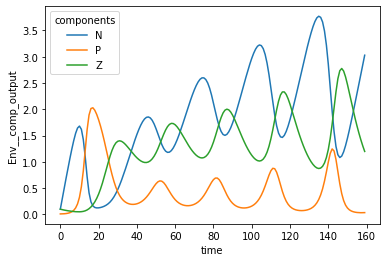

In [13]:
out_ds.Env__comp_output.plot.line(x='time')#, ylim=(0,2.5))  # (0,2.5)
#out_ds.Env__comp_output.isel(components=slice(1,-1)).sum(axis=0).plot.line(x='time')

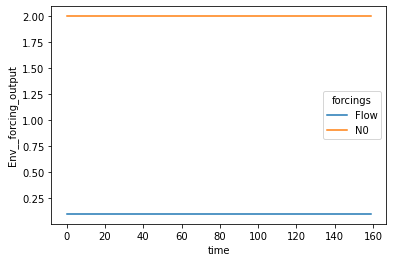

In [14]:
out_ds.Env__forcing_output.plot.line(x='time')

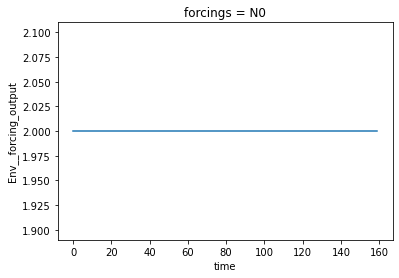

In [15]:
out_ds.Env__forcing_output.sel(forcings='N0').plot(x='time')  #, time=np.arange(300,400)

In [ ]:
out_ds.Env__flux_output.plot.line(x='time')

In [ ]:
out_ds.Env__fxflux_output.plot.line(x='time')